# Athens Airbnb Inference Analysis of Listing Price

#### STAT 301 - Group 31: Angela Li, Tyler Yih, Rex Ren, Diamond Wang (Dec. 6th, 2025)

## Introduction

The Airbnb market in Athens is influenced by a variety of social, geographical, and property-specific factors that shape pricing strategies and determine the relative affordability of listings. Understanding these influences can provide valuable insights for hosts aiming to optimize their revenue and for guests seeking cost-effective accommodations.

In this study, we aim to examine the association between the price of the accommodation for two people and two nights and predictors related to the room characteristics (e.g. type, # of bedrooms, etc.) and the timing of stay (i.e. weekday vs weekend).

Our primary goal is inference: we aim to identify which features are statistically significantly associated with price and to estimate their relative magnitudes. By fitting and comparing several models using the same response variable, this analysis seeks to clarify the complex set of factors associated with Airbnb pricing in Athens.

## Method and Results

### a) Data

#### Loading data

In [23]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(modelr)
library(AER)
library(leaps)

In [24]:
# Airbnb data in Athens on weekdays
weekdays <- read_csv("https://raw.githubusercontent.com/tyih985/athens-airbnb/refs/heads/main/data/athens_weekdays.csv")
# Airbnb data in Athens on weekends
weekends <- read_csv("https://raw.githubusercontent.com/tyih985/athens-airbnb/refs/heads/main/data/athens_weekends.csv")

New names:
• `` -> `...1`
Rows: 2653 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 2627 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Source and information
- The data was collected with web-scraping done with the help of a web-automation framework (Selenium WebDriver) during a study done by Gyódi, Kristóf and Nawaro, Łukasz, and attractiveness was based on TripAdvisor data.
- The data, provided by the University of Warsaw, was used to collect Airbnb offers that would be presented to a real user.

#### Citation
- https://doi.org/10.5281/zenodo.4446043
- https://doi.org/10.1016/j.tourman.2021.104319

### Variables

#### Descriptive summary
- Our assigned dataset offers detailed information on Airbnb listings in Athens, Greece, for both weekdays and weekends.
- The weekdays dataset consists of 2,653 entries, and the weekends dataset consists of 2,627 entries.
- Both datasets have 20 variables, whose names, descriptions, and types are provided in the table below.

#### Pre-selection of variables
- We likely will drop `room_shared`, and `room_private,` as `room_type` has overlapping information with the booleans about the type of room in the listing.
- In addition, both `attr_index` and `rest_index` heavily overlap with their normalized counterparts, so we only need to use one; likely the normalized version, so we would drop `attr_index` and `rest_index`.
- The index column does not contain very useful information so we would drop that as well.
- Lastly, we will remove `lng` and `lat` since we don't cover spatial analysis in this course.

| Variable Name                 | Description                                                     | Type        |
|-------------------------------|-----------------------------------------------------------------|-------------|
| `(index)`                     | Index of the row in the table                                   | Numeric     |
| `realSum`                     | Full price of accommodation for two people and two nights (EUR) | Numeric     |
| `room_type`                   | Type of the accommodation                                       | Categorical |
| `room_shared`                 | Whether the room is shared                                      | Boolean     |
| `room_private`                | Whether the room is private                                     | Boolean     |
| `person_capacity`             | Maximum number of guests                                        | Numeric     |
| `host_is_superhost`           | Whether the host is a superhost                                 | Boolean     |
| `multi`                       | Whether the listing belongs to hosts with 2-4 offers            | Boolean     |
| `biz`                         | Whether the listing belongs to hosts with more than 4 offers    | Boolean     |
| `cleanliness_rating`          | Cleanliness rating of the listing                               | Numeric     |
| `guest_satisfaction_overall`  | Overall guest satisfaction rating                               | Numeric     |
| `bedrooms`                    | Number of bedrooms in the listing (0 for studios)               | Numeric     |
| `dist`                        | Distance from the city centre (km)                              | Numeric     |
| `metro_dist`                  | Distance from the nearest metro station (km)                    | Numeric     |
| `attr_index`                  | Attraction index of the listing location                        | Numeric     |
| `attr_index_norm`             | Normalized attraction index (0-100)                             | Numeric     |
| `rest_index`                  | Restaurant index of the listing location                        | Numeric     |
| `rest_index_norm`             | Normalized restaurant index (0-100)                             | Numeric     |
| `lng`                         | Longitude of the listing location                               | Numeric     |
| `lat`                         | Latitude of the listing location                                | Numeric     |


### b) Exploratory Data Analysis (EDA)

#### Clean/wrangling data

In [25]:
# combine weekday and weekend datasets, creating new 
athens_raw <- bind_rows(
  mutate(weekdays, day_type = "weekday"),
  mutate(weekends, day_type = "weekend")
)

head(athens_raw)

...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,day_type
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,129.82448,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,10,⋯,2,2.8139635,0.8818900,55.34857,2.086871,78.77838,5.915160,23.76600,37.98300,weekday
1,138.96375,Entire home/apt,FALSE,FALSE,4,TRUE,1,0,10,⋯,1,0.4072929,0.3045679,240.30665,9.060559,407.16770,30.572629,23.73168,37.97776,weekday
2,156.30492,Entire home/apt,FALSE,FALSE,3,TRUE,0,1,10,⋯,1,1.2372111,0.2884881,199.50737,7.522257,395.96740,29.731642,23.72200,37.97900,weekday
3,91.62702,Entire home/apt,FALSE,FALSE,4,TRUE,1,0,10,⋯,1,4.3674572,0.2974673,39.80305,1.500740,58.70658,4.408047,23.72712,38.01435,weekday
4,74.05151,Private room,FALSE,TRUE,2,FALSE,0,0,10,⋯,1,2.1941850,0.3852657,78.73340,2.968577,113.32597,8.509204,23.73391,37.99529,weekday
5,113.88934,Entire home/apt,FALSE,FALSE,6,TRUE,1,0,10,⋯,2,2.0712056,0.4538674,96.58899,3.641806,158.64432,11.911981,23.71584,37.98598,weekday


In [26]:
athens <- athens_raw %>%
    # rename realSum tp real_sum
    rename(real_sum = realSum) %>%
    mutate(
        # convert room_type to factor
        room_type = fct_recode(room_type,
                                "entire" = "Entire home/apt",
                                "private" = "Private room",
                                "shared" = "Shared room"),
        # convert day_type to factor
        day_type = as_factor(day_type),
        
        # create a new categorical column 'num_host_offers'
        num_host_offers = case_when(
          biz == 1 ~ "moreThanFour",
          multi == 1 ~ "twoToFour",
          TRUE ~ "one"
        ),
        
        # make num_host_offers a factor
        num_host_offers = as_factor(num_host_offers)
    ) %>% 

    # remove index, room_shared, room_private, multi, biz, attr_index, rest_index and longitude and latitude (since we cannot do spatial analysis)
    select(-...1, -room_shared, -room_private, -multi, -biz, -attr_index, -rest_index, -lng, -lat)

head(athens)

real_sum,room_type,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,day_type,num_host_offers
<dbl>,<fct>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
129.82448,entire,4,FALSE,10,100,2,2.8139635,0.8818900,2.086871,5.915160,weekday,one
138.96375,entire,4,TRUE,10,96,1,0.4072929,0.3045679,9.060559,30.572629,weekday,twoToFour
156.30492,entire,3,TRUE,10,98,1,1.2372111,0.2884881,7.522257,29.731642,weekday,moreThanFour
91.62702,entire,4,TRUE,10,99,1,4.3674572,0.2974673,1.500740,4.408047,weekday,twoToFour
74.05151,private,2,FALSE,10,100,1,2.1941850,0.3852657,2.968577,8.509204,weekday,one
113.88934,entire,6,TRUE,10,96,2,2.0712056,0.4538674,3.641806,11.911981,weekday,twoToFour


#### Visualizations

##### 1. Violin Plot

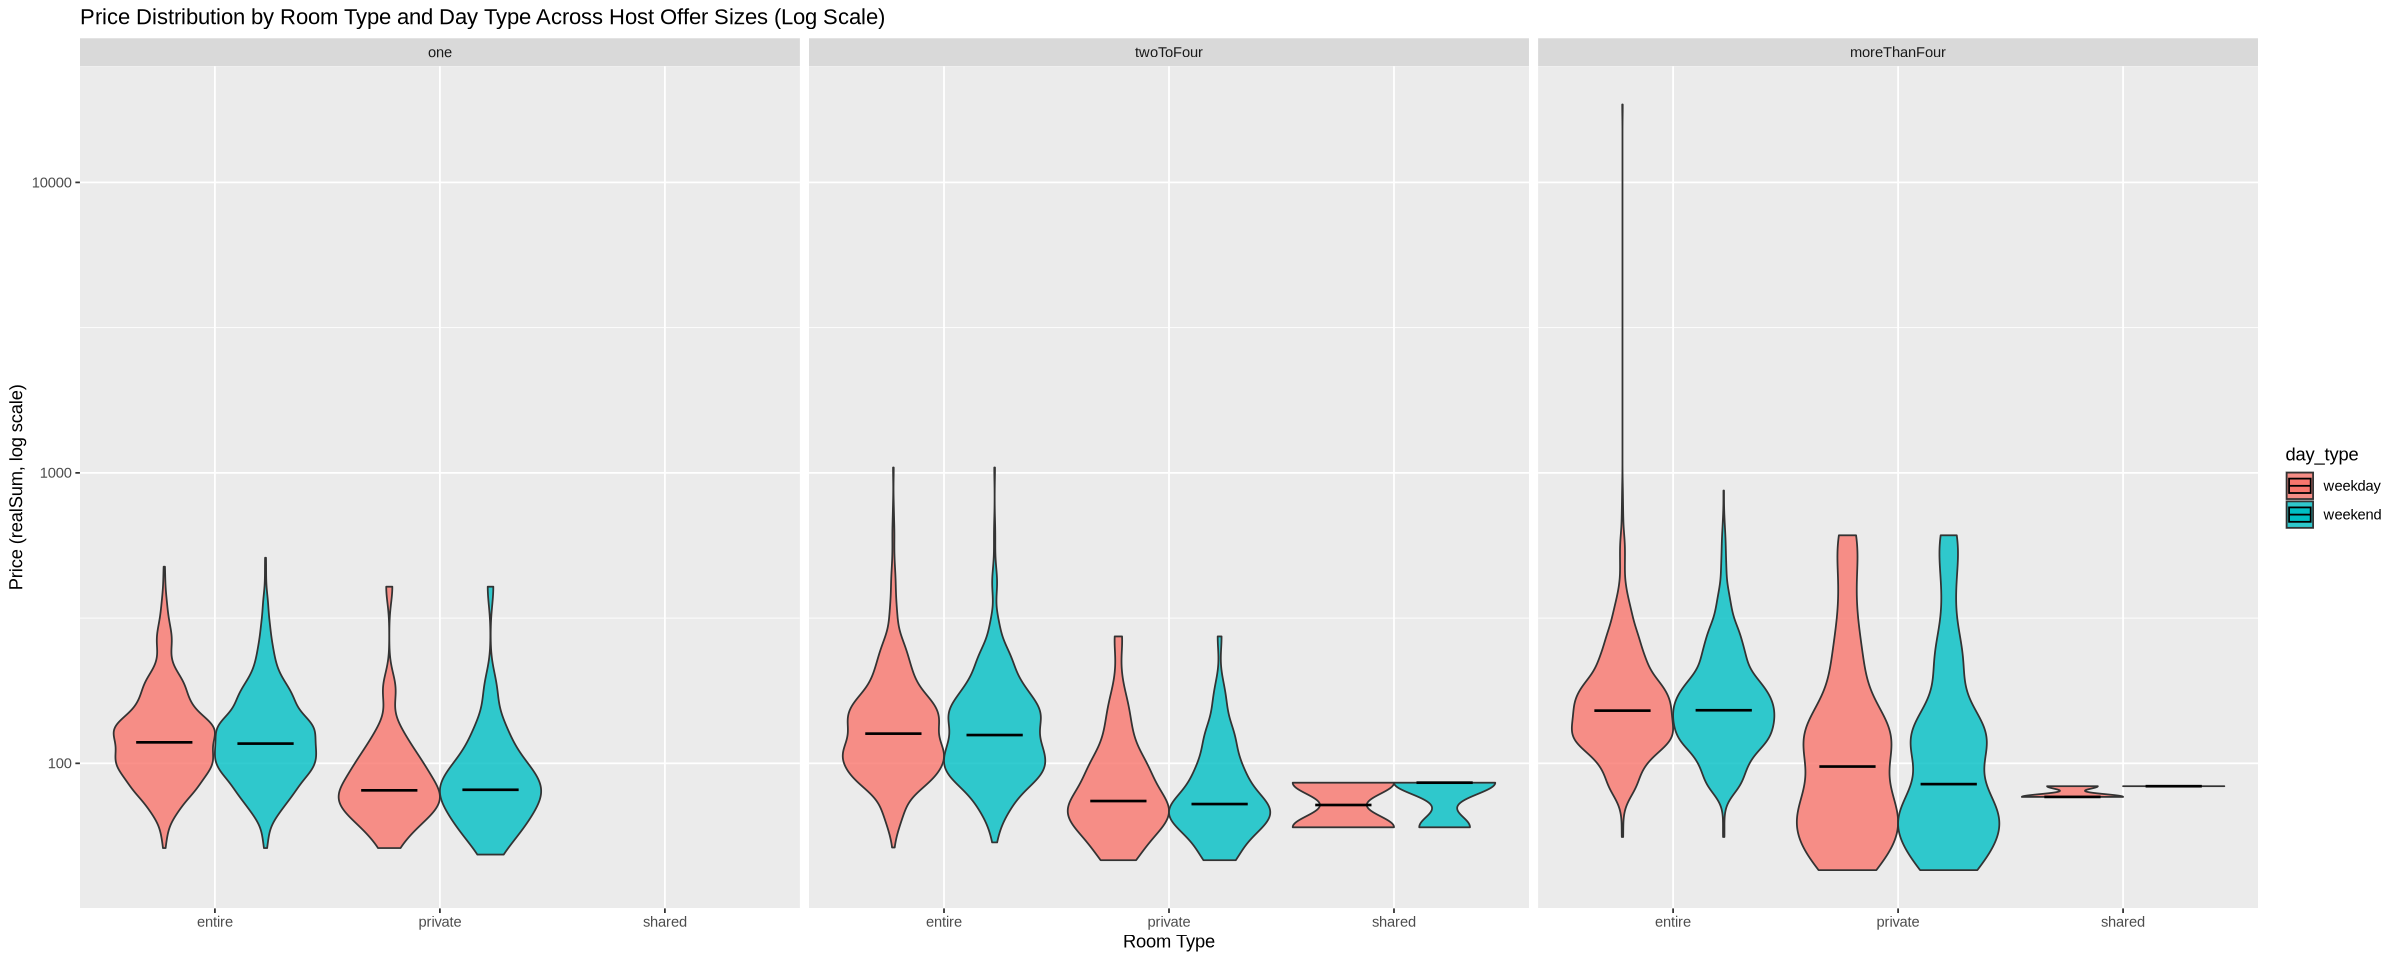

In [27]:
options(repr.plot.width = 20, repr.plot.height = 8)

ggplot(athens, aes(x = room_type, y = real_sum, fill = day_type)) +
  geom_violin(scale = "width", trim = TRUE, alpha = 0.8, position = position_dodge(width = 0.9)) +
  stat_summary(
    fun = median,
    geom = "crossbar",
    width = 0.5,
    color = "black",
    fatten = 1.5,
    position = position_dodge(width = 0.9)
  ) +
  scale_y_log10() +
  facet_wrap(~ num_host_offers) +
  labs(
    title = "Price Distribution by Room Type and Day Type Across Host Offer Sizes (Log Scale)",
    y = "Price (realSum, log scale)",
    x = "Room Type"
  )

##### Relevance
- These violin plots are relevant to address the question and explores the data because it visually explores how accommodation prices (realSum) vary by room type, weekday vs weekend, and number of host offers, which are all key variables related to room characteristics and timing of stay which may influence pricing.
- Faceting by host offer size allows us to compare pricing patterns across hosts with few versus many listings and look at the variability across the categories.

##### Interpretation of Results
- The original data is heavily right-skewed, so we log-transformed the price axis to reduce skewness.
- For weekday vs. weekend, price distributions are similar for some room type x host offer size combinations (e.g., entire rooms or private rooms with one or two-to-four listings) and show small differences for others (e.g. shared rooms or private rooms with more-than-four listings), while for room type, entire homes remain the most expensive and shared and private rooms have lower, more stable prices.
- The violin plots reveal that price distributions across room types deviate from normality, as several have long upper tails, and some show two distinct peaks, indicating bimodality.

##### What is Learned
- Price does not appear to differ consistently between weekdays and weekends, whereas room type shows a clearer relationship with price.
- A prominent outlier in the weekday × entire room × more-than-four-listings category suggests an unusually high-priced property that could distort model estimates if not addressed.
- The long upper tails in several distributions, even on the log scale, indicate residual skewness and possible heteroskedasticity, which could violate regression assumptions and should be considered in modeling.

##### 2. Histogram

In [28]:
# remove outliers with IQR

# Create log-price variable
athens$log_price <- log(athens$real_sum)

# Compute IQR bounds for log_price
Q1  <- quantile(athens$log_price, 0.25, na.rm = TRUE)
Q3  <- quantile(athens$log_price, 0.75, na.rm = TRUE)
IQR_value <- IQR(athens$log_price, na.rm = TRUE)

lower <- Q1 - 1.5 * IQR_value
upper <- Q3 + 1.5 * IQR_value

# Filter data
athens_clean <- athens[athens$log_price >= lower & athens$log_price <= upper, ]

# Report removed points
cat("Removed:", nrow(athens) - nrow(athens_clean), "outliers\n")
cat("Remaining:", nrow(athens_clean), "observations\n")

Removed: 107 outliers
Remaining: 5173 observations


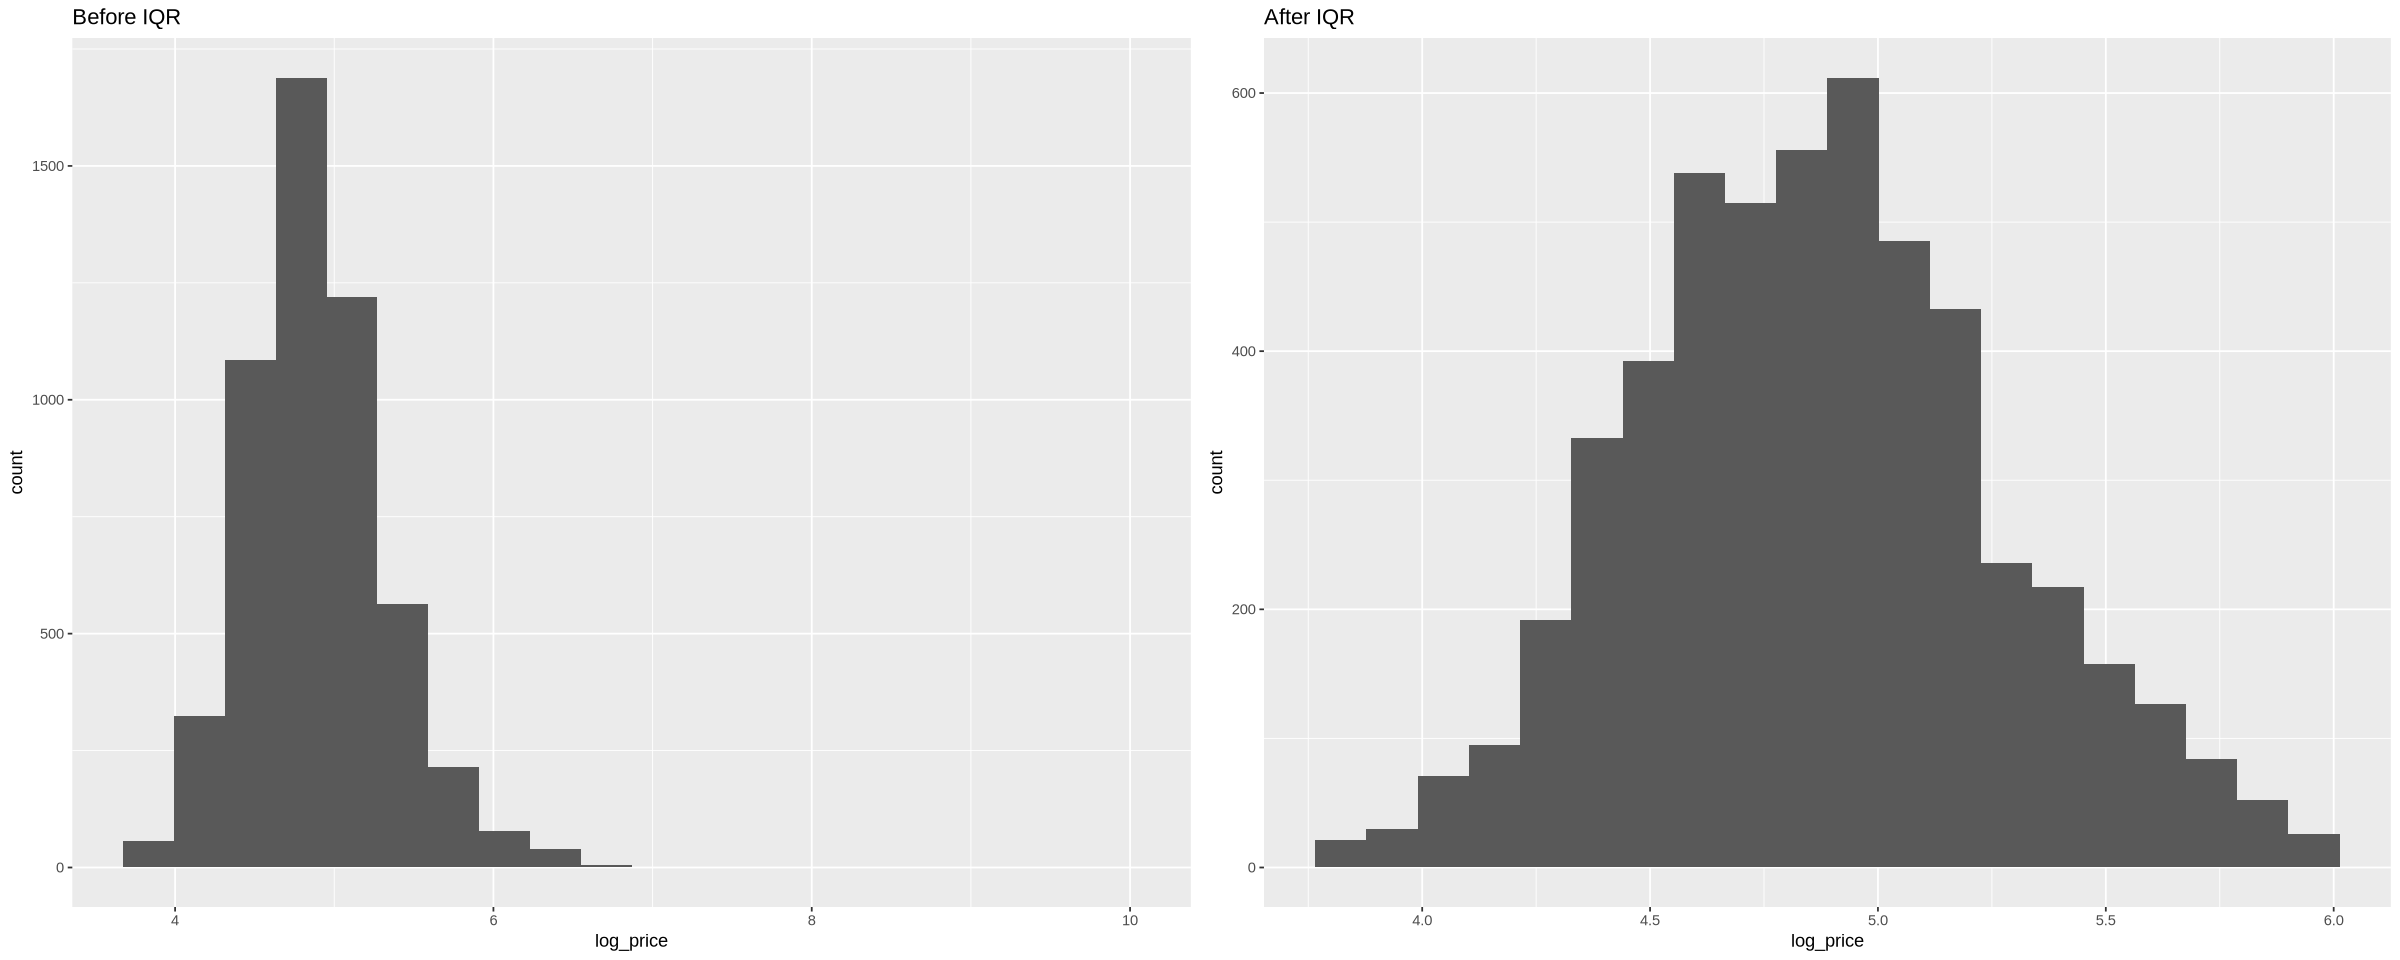

In [29]:
# Compare distributions
p1 <- ggplot(athens, aes(x = log_price)) +
  geom_histogram(bins = 20) +
  labs(title = "Before IQR")

p2 <- ggplot(athens_clean, aes(x = log_price)) +
  geom_histogram(bins = 20) +
  labs(title = "After IQR")

plot_grid(p1, p2, ncol = 2)

We can see that originally, even after log-transforming the response variable (`real_sum`), the distribution remains slightly right-skewed and still contains several outliers. This is further supported by the violin plots, where the long, extended density tails indicate extreme values in the data. After applying IQR-based outlier removal, the distribution of `real_sum` becomes much more symmetric and substantially closer to a normal shape, suggesting that the cleaning procedure effectively reduced the influence of extreme observations.

#### Summary Tables

In [30]:
# get summary of the dataset
summary(athens_clean)

    real_sum        room_type    person_capacity host_is_superhost
 Min.   : 45.23   entire :4786   Min.   :2.000   Mode :logical    
 1st Qu.: 98.66   private: 376   1st Qu.:2.000   FALSE:2949       
 Median :127.72   shared :  11   Median :4.000   TRUE :2224       
 Mean   :141.05                  Mean   :3.678                    
 3rd Qu.:168.02                  3rd Qu.:4.000                    
 Max.   :382.68                  Max.   :6.000                    
 cleanliness_rating guest_satisfaction_overall    bedrooms    
 Min.   : 2.000     Min.   : 20.00             Min.   :0.000  
 1st Qu.: 9.000     1st Qu.: 94.00             1st Qu.:1.000  
 Median :10.000     Median : 97.00             Median :1.000  
 Mean   : 9.637     Mean   : 94.99             Mean   :1.262  
 3rd Qu.:10.000     3rd Qu.:100.00             3rd Qu.:2.000  
 Max.   :10.000     Max.   :100.00             Max.   :3.000  
      dist           metro_dist      attr_index_norm   rest_index_norm   
 Min.   :0.07133

We can see the means, medians, min, max for the numeric columns, and we can see the number of rows corresponding to each category for the categorical columns.

In [31]:
# get number of N/As in the dataset
colSums(is.na(athens_clean))

real_sum                  room_type 
                         0                          0 
           person_capacity          host_is_superhost 
                         0                          0 
        cleanliness_rating guest_satisfaction_overall 
                         0                          0 
                  bedrooms                       dist 
                         0                          0 
                metro_dist            attr_index_norm 
                         0                          0 
           rest_index_norm                   day_type 
                         0                          0 
           num_host_offers                  log_price 
                         0                          0

There are no N/As in our dataset.

### c) Method and Plan 

#### Proposed Method
We will begin by considering a comprehensive set of potential explanatory variables related to Airbnb prices in Athens. We will model the log-transformed price as the response variable since price is right-skewed. Since spatial analysis is not covered in this course, we do not use `lat` nor `lng`. **We will also consider additional variables and potential interaction terms (e.g., room type × host offer size) to explore whether the effect of one characteristic will depend on another.**

We will apply LASSO regression with cross-validation to perform variable selection.

The subset of predictors selected by lasso will then be used to refit standard multiple linear regression models for interpretation and inference:

- Main-effects model - include all predictors selected by lasso.

- Interaction model - add selected interaction terms to assess whether associations differ across host or property characteristics.

##### Justification
- Log-transforming `real_sum` reduces right skew, stabilizes variance, and converts multiplicative effects into additive ones, allowing coefficients to be interpreted approximately as percentage changes in price.
- LASSO is an effective method for variable selection because it reduces the risk of overfitting and multicollinearity. By shrinking unimportant coefficients to zero, LASSO ensures that only the most relevant variables remain in the modeling process.
- Refitting MLR models using the LASSO-selected variables will allow for interpretable coefficient estimates, hypothesis testing, confidence intervals, and clear communication of model results.

##### Required Assumptions
- This method assumes:
  - Linearity between predictors and price (after any transformations).
  - Independence of listings.
  - Constant error variance (homoskedasticity).
  - Approximately normal residuals.
  - Adequate inclusion of relevant predictors through LASSO selection.

##### Potential Limitations and Weaknesses
- The linear model cannot naturally capture nonlinear relationships or interactions unless explicitly included.  
- Unobserved variables could bias estimates.
- Violations of homoskedasticity or normality may lead to unreliable standard errors and p-values.

#### Model Assessment Plan
We will evaluate model adequacy and compare model structures using the following procedures:

##### 1. Model Fit Metrics
- Adjusted R²
  - Measures the proportion of variance in log(price) explained by the predictors, adjusted for the number of predictors.
  - We're using adjusted R² instead of regular R² because we have a lot of predictors involved with our model.
- Root Mean Squared Error (RMSE)
  - Assesses the typical deviation between observed and predicted `log(real_sum)`.
  
##### 2. Q–Q Plot of Residuals
- Assesses whether the residuals are approximately normally distributed.  
- Points following the 45° reference line suggest that the normality assumption holds.  
- Systematic deviations or heavy tails indicate potential violations, which could affect the accuracy of confidence intervals and p-values.

##### 3. Residuals vs. Fitted Plot
- Examines the relationship between residuals and fitted values to check for model assumptions.  
- A random scatter of points around zero suggests that:  
  - The linearity assumption is reasonable.  
  - The residual variance is approximately constant (homoscedasticity).  
- Patterns such as curves or “funnel” shapes may indicate nonlinearity or heteroscedasticity, which could bias inference.

### d) Code and Results

In [32]:
# Attach packages
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(modelr)
library(glmnet)
library(tidymodels)

In [33]:
# Airbnb data in Athens on weekdays
weekdays <- read_csv("https://raw.githubusercontent.com/tyih985/athens-airbnb/refs/heads/main/data/athens_weekdays.csv")
# Airbnb data in Athens on weekends
weekends <- read_csv("https://raw.githubusercontent.com/tyih985/athens-airbnb/refs/heads/main/data/athens_weekends.csv")

New names:
• `` -> `...1`
Rows: 2653 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 2627 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Tidy/wrangle data

In [34]:
# combine weekday and weekend datasets, creating new 
athens_raw <- bind_rows(
  mutate(weekdays, day_type = "weekday"),
  mutate(weekends, day_type = "weekend")
)

# head(athens_raw)

In [35]:
athens <- athens_raw %>%
    # rename realSum
    rename(real_sum = realSum) %>%
    mutate(
        # convert room_type to factor
        room_type = fct_recode(room_type,
                                "entire" = "Entire home/apt",
                                "private" = "Private room",
                                "shared" = "Shared room"),
        # convert day_type to factor
        day_type = as_factor(day_type),
        
        # create a new categorical column 'num_host_offers'
        num_host_offers = case_when(
          biz == 1 ~ "moreThanFour",
          multi == 1 ~ "twoToFour",
          TRUE ~ "one"
        ),
        
        # make num_host_offers a factor
        num_host_offers = as_factor(num_host_offers)
    ) %>% 

    # remove index, room_shared, room_private, multi, biz, attr_index, rest_index and longitude and latitude (since we cannot do spatial analysis)
    select(- `...1`, -room_shared, -room_private, -multi, -biz, -attr_index, -rest_index, -lng, -lat)

head(athens)

real_sum,room_type,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,day_type,num_host_offers
<dbl>,<fct>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
129.82448,entire,4,FALSE,10,100,2,2.8139635,0.8818900,2.086871,5.915160,weekday,one
138.96375,entire,4,TRUE,10,96,1,0.4072929,0.3045679,9.060559,30.572629,weekday,twoToFour
156.30492,entire,3,TRUE,10,98,1,1.2372111,0.2884881,7.522257,29.731642,weekday,moreThanFour
91.62702,entire,4,TRUE,10,99,1,4.3674572,0.2974673,1.500740,4.408047,weekday,twoToFour
74.05151,private,2,FALSE,10,100,1,2.1941850,0.3852657,2.968577,8.509204,weekday,one
113.88934,entire,6,TRUE,10,96,2,2.0712056,0.4538674,3.641806,11.911981,weekday,twoToFour


In [36]:
# remove outliers with IQR

# Create log-price variable
athens$log_price <- log(athens$real_sum)

# Compute IQR bounds for log_price
Q1  <- quantile(athens$log_price, 0.25, na.rm = TRUE)
Q3  <- quantile(athens$log_price, 0.75, na.rm = TRUE)
IQR_value <- IQR(athens$log_price, na.rm = TRUE)

lower <- Q1 - 1.5 * IQR_value
upper <- Q3 + 1.5 * IQR_value

# Filter data
athens_clean <- athens[athens$log_price >= lower & athens$log_price <= upper, ]

# Report removed points
cat("Removed:", nrow(athens) - nrow(athens_clean), "outliers\n")
cat("Remaining:", nrow(athens_clean), "observations\n")

Removed: 107 outliers
Remaining: 5173 observations


#### Split Data

In [37]:
set.seed(301)
athens_split <- initial_split(athens_clean, prop = 0.6, strata = log_price)
athens_train <- training(athens_split)
athens_test <- testing(athens_split)

In [38]:
# create model matrix
x_train <- model.matrix(
  log_price ~ . - real_sum,
  data = athens_train
)[, -1]  # drop intercept

y_train <- athens_train$log_price

In [39]:
set.seed(123)

cv_lasso <- cv.glmnet(
  x_train,
  y_train,
  alpha = 1
)

cv_lasso


Call:  cv.glmnet(x = x_train, y = y_train, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index Measure       SE Nonzero
min 0.000491    64 0.08404 0.003325      14
1se 0.016849    26 0.08698 0.003239      11

In [40]:
# extract best (smallest MSE) lasso model
beta_lasso <- coef(cv_lasso, s = "lambda.min")

# extract covariates
lasso_selected_covariates <- as_tibble(
        as.matrix(beta_lasso),
        rownames='covariate') %>%
        filter(covariate != '(Intercept)' & abs(s1) !=0) %>% 
        pull(covariate)

lasso_selected_covariates

[1] "room_typeprivate"            "room_typeshared"            
 [3] "person_capacity"             "host_is_superhostTRUE"      
 [5] "cleanliness_rating"          "guest_satisfaction_overall" 
 [7] "bedrooms"                    "dist"                       
 [9] "metro_dist"                  "attr_index_norm"            
[11] "rest_index_norm"             "day_typeweekend"            
[13] "num_host_offerstwoToFour"    "num_host_offersmoreThanFour"

In [41]:
# fit MLR with LASSO selected covariates
mlr_lasso <- lm(formula = log_price ~ room_type + person_capacity + host_is_superhost + cleanliness_rating + bedrooms + dist + metro_dist + attr_index_norm + rest_index_norm + day_type + num_host_offers, 
              data = athens_test)

mlr_lasso_res <- tidy(mlr_lasso, conf.int = TRUE) |>
    mutate_if(is.numeric, round, 3)

In [42]:
# fit MLR with LASSO selected covariates
mlr_lasso <- lm(formula = log_price ~ room_type + person_capacity + host_is_superhost + cleanliness_rating + bedrooms + dist + metro_dist + attr_index_norm + rest_index_norm + day_type + num_host_offers, 
              data = athens_test)

mlr_lasso_res <- tidy(mlr_lasso, conf.int = TRUE) |>
    mutate_if(is.numeric, round, 3)

# fit base MLR
mlr_base <- lm(log_price ~ . - real_sum,
               data = athens_test)

mlr_base_res <- tidy(mlr_base, conf.int = TRUE) |>
    mutate_if(is.numeric, round, 3)

In [43]:
# display results in one table
combined_res <- bind_rows(mlr_lasso_res |> mutate(model = "LASSO"),
                          mlr_base_res |> mutate(model = "Base")) |> 
                select(model, term, estimate, std.error, statistic, p.value, conf.low, conf.high) |>
                pivot_wider(names_from = model, values_from = c(estimate, std.error, statistic, p.value, conf.low, conf.high))

combined_res

term,estimate_LASSO,estimate_Base,std.error_LASSO,std.error_Base,statistic_LASSO,statistic_Base,p.value_LASSO,p.value_Base,conf.low_LASSO,conf.low_Base,conf.high_LASSO,conf.high_Base
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.946,3.909,0.081,0.085,48.817,46.242,0.000,0.000,3.787,3.743,4.104,4.075
room_typeprivate,-0.298,-0.299,0.025,0.025,-11.938,-11.978,0.000,0.000,-0.347,-0.348,-0.249,-0.250
room_typeshared,-0.372,-0.382,0.145,0.146,-2.557,-2.625,0.011,0.009,-0.657,-0.668,-0.087,-0.097
person_capacity,0.060,0.059,0.007,0.007,8.845,8.744,0.000,0.000,0.047,0.046,0.073,0.073
host_is_superhostTRUE,0.034,0.033,0.013,0.013,2.533,2.417,0.011,0.016,0.008,0.006,0.060,0.059
cleanliness_rating,0.048,0.035,0.008,0.012,6.392,2.938,0.000,0.003,0.033,0.012,0.063,0.058
bedrooms,0.117,0.117,0.013,0.013,8.878,8.898,0.000,0.000,0.091,0.091,0.143,0.143
dist,-0.072,-0.072,0.009,0.009,-8.315,-8.293,0.000,0.000,-0.090,-0.089,-0.055,-0.055
metro_dist,-0.093,-0.093,0.024,0.024,-3.930,-3.944,0.000,0.000,-0.139,-0.139,-0.046,-0.047


<mark>**All this no longer applies!! actually everything below here is probably wrong now!!**

The regression results indicate that, using a significance level of **0.05**, most predictors have statistically significant effects on the outcome.
Relative to the reference `room_type`, private rooms are associated with about a **26%** lower price (`exp(−0.307) − 1 = ~−0.26`), and shared rooms with about a **37%** lower price (`exp(−0.458) − 1 = ~−0.37`).

Larger listings tend to be more expensive: each additional unit of person capacity predicts roughly a **6.7%** increase in price (`exp(0.0653) − 1 = ~0.067`), each additional bedroom predicts about an **11%** increase (`exp(0.1064) − 1 = ~0.112`), and each additional point of cleanliness rating corresponds to about a **5%** increase in price (`exp(0.0499) − 1 = ~0.051`).

Being a superhost is associated with a small but significant price increase of about **3.4%** (`exp(0.0331) − 1 = ~0.034`).
Environmental and location-based features also matter: a greater distance from the center and metro stations is associated with roughly **8%** lower price per unit of distance (`exp(−0.0822) − 1 = ~−0.079`; `exp(−0.0826) − 1 = ~−0.079`).

Higher attractiveness and restaurant index values are associated with small but significant percentage increases in price (`exp(0.0149) − 1 = ~0.015`; `exp(0.0069) − 1 = ~0.007`). 

Weekend days are priced about **10%** higher than weekdays (`exp(0.0955) − 1 = ~0.100`).

Hosts who manage more listings tend to charge more, with those having more than four listings pricing about **16%** higher than the reference group (`exp(0.1467) − 1 = ~0.158`).
The only predictor that is not statistically significant is guest satisfaction overall (`p = 0.18`), suggesting no strong evidence of an effect.

Overall, the model identifies several meaningful contributors to variation in the outcome, with room type, distance, and size-related attributes showing the strongest effects.

In [44]:
# Obtain metrics for evaluation
glance(mlr_fit)

ERROR: Error in eval(expr, envir, enclos): object 'mlr_fit' not found


The model’s adjusted R² score is `~0.4766`, meaning the predictors in our regression explain about `47.7%` of the variation in `log(real_sum)` once the number of predictors is taken into account. This level of fit suggests that the model captures several meaningful patterns in Airbnb prices but still leaves a portion of the variability unexplained. The RMSE on the log scale is `~0.2886`, showing the average difference between the observed and predicted log prices. Converting this to the original price scale gives `exp(0.2886) = ~1.335` for positive errors and `exp(-0.2886) = ~0.749` for negative errors, which means a typical prediction is either `33%` too high or `25%` too low. Overall, these two metrics together suggest that our model performs reasonably well for a complex real-world dataset and is useful for understanding broad pricing relationships.

In [ ]:
#Q-Q plot of residuals
plot(mlr_fit, 2)

This is Q–Q plot of standardized residuals from the multiple linear regression shows that although points lie close to the line near the center, they deviate in the tails. This indicattes mild non-normality in residuals driven by a few high-residual observations.

## Discussion

#### Implications

Our analysis reveals that Airbnb prices in Athens are shaped by a combination of listing characteristics, host attributes, and geographic factors, with several variables showing statistically significant associations with price. In a log-linear model of price, `room_type` emerged as one of the strongest predictors: private and shared rooms were substantially cheaper than the reference category of entire homes, reflecting market segmentation based on privacy levels. Property size characteristics, including the number of bedrooms and guest capacity, were also positively associated with price, indicating that larger accommodations reliably command higher revenue. Cleanliness ratings and neighbourhood amenities (captured by attractiveness and restaurant indices) similarly contributed to price premiums. Geographic access also mattered, as listings farther from central points tended to be priced lower, which aligns with our expectations about accessibility affecting demand. In contrast, guest satisfaction ratings did not have a statistically significant effect after controlling for other variables, implying that factors like room type and location may overshadow general guest sentiment in determining price.

Overall, these findings generally aligned with expectations. We anticipated that privacy, size, and proximity would be major drivers of price, and the results confirmed these relationships. The lack of a significant effect from guest satisfaction was somewhat surprising, as we initially expected higher-rated listings to command higher prices.

#### Model Limitations and Suggested Improvements

- **Non-normality of Residuals**  
  *Limitation:* The Q–Q plot of standardized residuals shows that points deviate from the line in the tails, indicating mild non-normality driven by a few high-residual observations. This could slightly affect the accuracy of confidence intervals and p-values.  
  *Improvement:* Consider applying robust standard errors or transforming predictors with extreme influence. Additionally, alternative regression approaches (e.g., generalized linear models or quantile regression) could reduce sensitivity to tail deviations.

- **Linearity Assumption**  
  *Limitation:* The model assumes a linear relationship between `log(real_sum)` and each covariate, but nonlinear effects may exist that are not captured.  
  *Improvement:* Examine residuals vs. predictors plots and consider adding polynomial or spline terms to better capture nonlinear relationships.

- **Multicollinearity**  
  *Limitation:* Some predictors may be correlated (e.g., `bedrooms` and `person_capacity`), inflating standard errors and reducing reliability of individual coefficient inference.  
  *Improvement:* Calculate variance inflation factors (VIFs) to identify problematic predictors. Highly correlated variables could be combined, removed, or regularized (e.g., using ridge regression) to reduce collinearity.

- **Omitted Variable Bias**  
  *Limitation:* Important predictors, such as temporal effects, neighborhood characteristics, or host-specific attributes, may be missing, potentially biasing estimates of included variables.  
  *Improvement:* Explore additional covariates and consider hierarchical or mixed-effects models that can account for clustering or unobserved factors.

#### Next Steps
This study opens several paths for further research. Future work could examine temporal dynamics by modelling how prices fluctuate seasonally or during local events, allowing for richer insights into demand cycles. Another direction would be to incorporate host-level factors such as response rate, cancellation policy, or listing age, which may influence pricing strategies. Finally, expanding the dataset to include additional cities or comparing Athens to similar European markets could help determine whether the pricing patterns we observed are city-specific or reflect broader trends in Airbnb markets.

## References

#### Airbnb Dataset:
- https://doi.org/10.5281/zenodo.4446043
- https://doi.org/10.1016/j.tourman.2021.104319

#### IQR Method: 
- https://online.stat.psu.edu/stat200/lesson/3/3.2